# MLP

By Alberto Valdés

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was devoloped in Google Colab using "T4 GPU".

A multilayer perceptron (MLP) is a misnomer for a modern feedforward artificial neural network, consisting of fully connected neurons with a nonlinear kind of activation function, organized in at least three layers, notable for being able to distinguish data that is not linearly separable.

It is a misnomer because the original perceptron used a Heaviside step function, instead of a nonlinear kind of activation function (used by modern networks).

Modern feedforward networks are trained using the backpropagation method and are colloquially referred to as the "vanilla" neural networks.

$ \ $

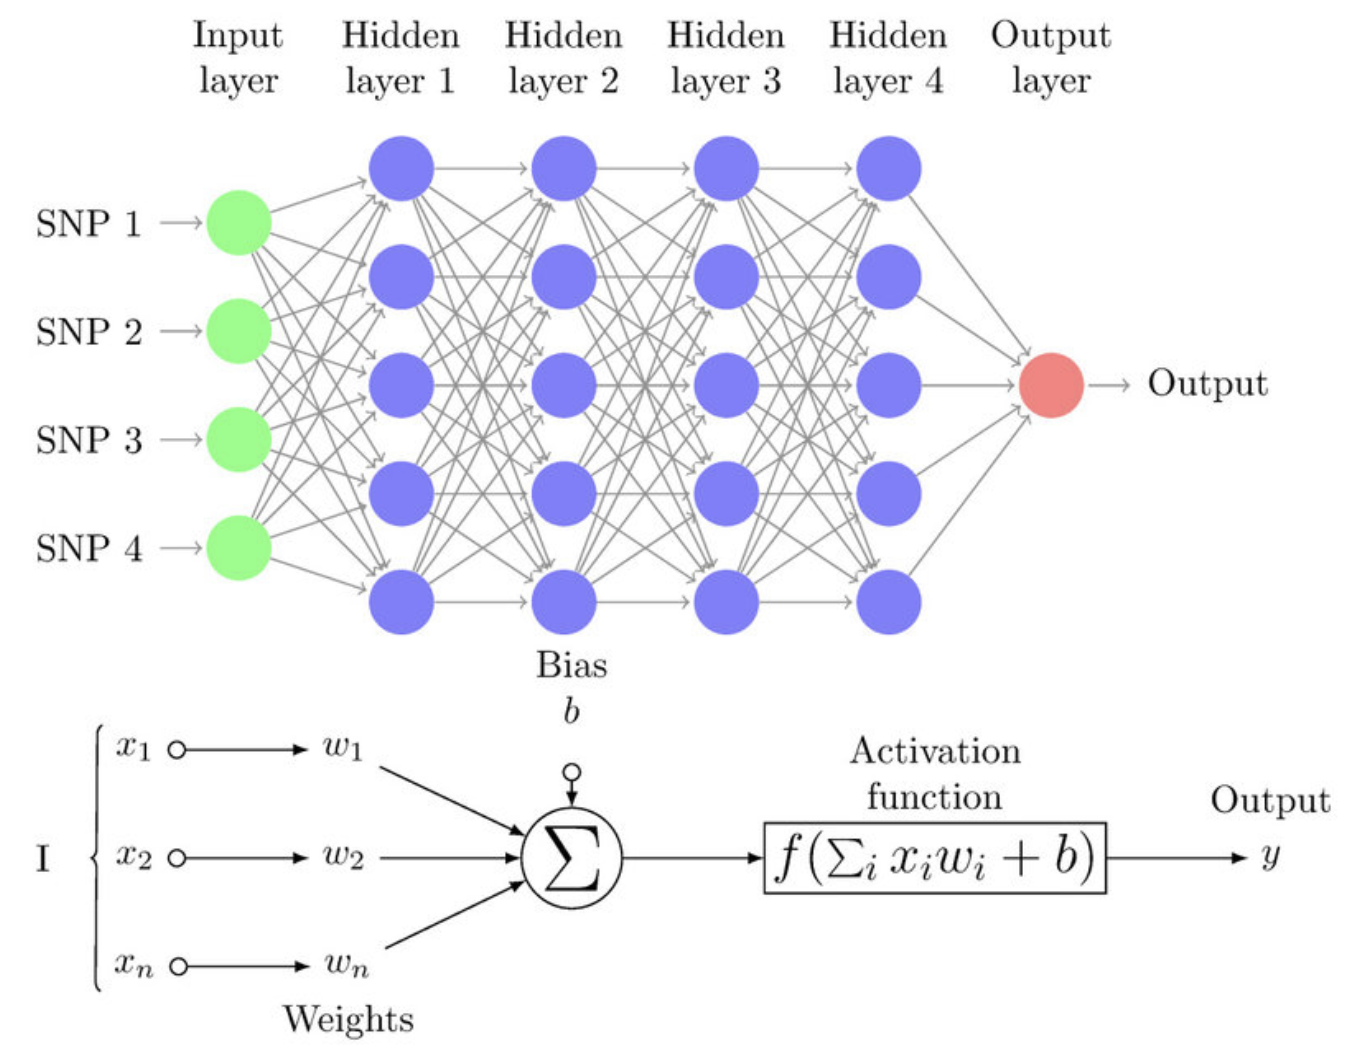

**Data Type at Entry:** Torch tensors.

**Data Type at Output:** Torch tensors.

In [1]:
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def print_time_execution(start, end, txt):

  delta = int(end - start)

  hours = int(delta/3_600)
  mins = int((delta - 3_600*hours)/60)
  segs = int(delta - hours*3600 - mins*60)

  return f'{txt} it takes {hours} hours, {mins} mins and {segs} segs.'

In [3]:
def creation_batchs(n_batchs, X_train, y_train):

  N_train = len(X_train)
  N_batch = int(N_train/n_batchs) + 1

  all_X_train = []
  all_y_train = []

  for i in range(n_batchs):

    all_X_train.append(X_train[i*N_batch: (i+1)*N_batch].copy())
    all_y_train.append(y_train[i*N_batch: (i+1)*N_batch].copy())

  return all_X_train, all_y_train

### Start time of execution

In [4]:
start = time.time()

# 1. Regresion Problem

### i. Creacion of Dataset

In [5]:
X = [(i*0.1 - 20) for i in range(1, 400 + 1)]

In [6]:
y = [x**2 for x in X]

In [7]:
df = pd.DataFrame({'X': X, 'y': y})

In [8]:
df['X'] = df['X'].astype('float32')
df['y'] = df['y'].astype('float32')

In [9]:
X = df[['X']].copy()
y = df['y'].copy()

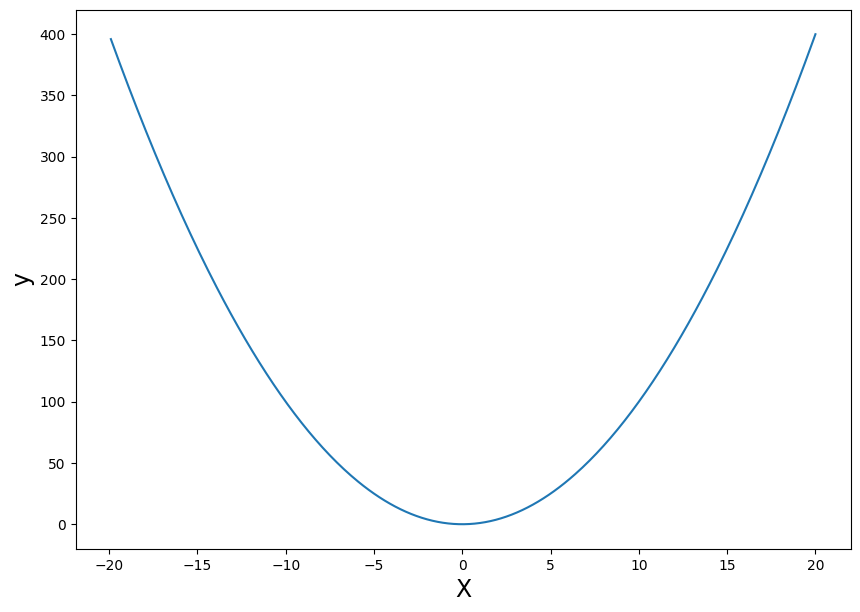

In [10]:
plt.figure(figsize = (10, 7))
plt.xlabel('X', fontsize = 17)
plt.ylabel('y', fontsize = 17)
plt.plot(X, y)
plt.show()

### ii. Split

In [11]:
n_batchs = 2

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.5, random_state = 42)

In [13]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state = 42)

In [14]:
X_train_mean = X_train.mean()
X_train_std = X_train.std()

X_train = (X_train - X_train_mean)/X_train_std
X_val = (X_val - X_train_mean)/X_train_std
X_test = (X_test - X_train_mean)/X_train_std

In [15]:
y_train_mean = y_train.mean()
y_train_std = y_train.std()

y_train = (y_train - y_train_mean)/y_train_std
y_val = (y_val - y_train_mean)/y_train_std
y_test = (y_test - y_train_mean)/y_train_std

In [16]:
all_X_train, all_y_train = creation_batchs(n_batchs, X_train, y_train)

In [17]:
for i in range(n_batchs):
  all_X_train[i] = torch.tensor(np.array(all_X_train[i]))
  all_y_train[i] = torch.tensor(np.array(all_y_train[i]))

X_train = torch.tensor(np.array(X_train))
y_train = torch.tensor(np.array(y_train))

X_val = torch.tensor(np.array(X_val))
y_val = torch.tensor(np.array(y_val))

X_test = torch.tensor(np.array(X_test))
y_test = torch.tensor(np.array(y_test))

### iii. Creation of model

In [18]:
class MLP(nn.Module):

    def __init__(self, input_size, hidden_dim_1, hidden_dim_2, output_size):
        super(MLP, self).__init__()

        #----------------------------------------------------------------------

        self.input_size = input_size

        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2

        self.output_size = output_size

        #----------------------------------------------------------------------

        self.fc_entry = nn.Linear(self.input_size, self.hidden_dim_1)

        self.fc_1 = nn.Linear(self.hidden_dim_1, self.hidden_dim_2)
        self.fc_2 = nn.Linear(self.hidden_dim_2, self.output_size)

        self.activation_1 = nn.ReLU()
        self.activation_2 = nn.ReLU()

        #----------------------------------------------------------------------


    def forward(self, x):

        out = self.fc_entry(x)
        out = self.activation_1(out)

        out = self.fc_1(out)
        out = self.activation_2(out)

        out = self.fc_2(out)

        return out

In [19]:
class Model():

  def __init__(self, input_size, hidden_dim_1, hidden_dim_2, output_size, n_epochs, lr):

    self.input_size = input_size
    self.hidden_dim_1 = hidden_dim_1
    self.hidden_dim_2 = hidden_dim_2
    self.output_size = output_size

    self.n_epochs = n_epochs
    self.lr = lr

    self.model = MLP(input_size, hidden_dim_1, hidden_dim_2, output_size)


  def train(self):

    start_train = time.time()

    #----------------------------------------------------------------------

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(self.model.parameters(), lr = self.lr)

    #----------------------------------------------------------------------

    all_train_loss = []
    all_val_loss = []
    all_epochs = []

    #----------------------------------------------------------------------

    for epoch in range(1, self.n_epochs + 1):

      # 1. Train

      self.model.train()

      loss_train_epoch = 0

      for n_iter in range(n_batchs):

        X_train_batch = all_X_train[n_iter]
        y_train_batch = all_y_train[n_iter]

        optimizer.zero_grad() # Clears existing gradients

        out_train_batch = self.model(X_train_batch)
        out_train_batch = torch.reshape(out_train_batch, (-1, ))

        loss_train_batch = criterion(out_train_batch, y_train_batch)

        loss_train_batch.backward()
        optimizer.step() # Updates the weights accordingly

        loss_train_epoch = loss_train_epoch + loss_train_batch.item()

      loss_train_epoch = loss_train_epoch/len(X_train)

      all_train_loss.append(loss_train_epoch)
      all_epochs.append(epoch)

      # 2. Validation

      self.model.eval()

      out_val = self.model(X_val)
      out_val = torch.reshape(out_val, (-1, ))

      loss_val = criterion(out_val, y_val).item()/len(X_val)

      all_val_loss.append(loss_val)

    #----------------------------------------------------------------------

    end_train = time.time()

    self.all_epochs = all_epochs

    self.all_train_loss = all_train_loss
    self.all_val_loss = all_val_loss

    return print_time_execution(start_train, end_train, 'in train the model')


  def plot_train(self):

    plt.figure(figsize = (10, 7))
    plt.title('Normal scale')
    plt.plot(self.all_epochs, self.all_train_loss, label = 'train', color = 'blue')
    plt.plot(self.all_epochs, self.all_val_loss, label = 'val', color = 'red')
    plt.legend()
    plt.show()

    print('\n')
    print('\n')
    print('\n')

    plt.figure(figsize = (10, 7))
    plt.title('Log scale')
    plt.plot(self.all_epochs, np.log(np.array(self.all_train_loss)), label = 'train', color = 'blue')
    plt.plot(self.all_epochs, np.log(np.array(self.all_val_loss)), label = 'val', color = 'red')
    plt.legend()
    plt.show()


  def evaluation_val_set(self):

    criterion = nn.MSELoss()

    self.model.eval()

    out_val = self.model(X_val)
    out_val = torch.reshape(out_val, (-1, ))

    loss_val = criterion(out_val, y_val).item()/len(X_val)

    return loss_val


### iv. Hyperparameter Tuning Jobs

In [20]:
input_size = 1
output_size = 1

all_hidden_dim_1 = [(i*2) for i in range(1, 5 + 1)]
all_hidden_dim_2 = [(i*2) for i in range(1, 5 + 1)]
all_n_epochs = [(i*100) for i in range(1, 5 + 1)]
all_lr = [(i*0.01) for i in range(1, 5 + 1)]

all_params = []

for hidden_dim_1 in all_hidden_dim_1:
  for hidden_dim_2 in all_hidden_dim_2:
    for n_epochs in all_n_epochs:
      for lr in all_lr:
        all_params.append({'hidden_dim_1': hidden_dim_1, 'hidden_dim_2': hidden_dim_2, 'n_epochs': n_epochs, 'lr': lr})

In [21]:
hidden_dim_1_col = []
hidden_dim_2_col = []

n_epochs_col = []
lr_col = []

loss_val_col = []

c = 0

start_iter = time.time()

m = 10

for params in all_params:

  c = c + 1

  hidden_dim_1 = params['hidden_dim_1']
  hidden_dim_2 = params['hidden_dim_2']

  n_epochs = params['n_epochs']
  lr = params['lr']

  model = Model(input_size, hidden_dim_1, hidden_dim_2, output_size, n_epochs, lr)
  _ = model.train()
  loss_val = model.evaluation_val_set()

  hidden_dim_1_col.append(hidden_dim_1)
  hidden_dim_2_col.append(hidden_dim_2)

  n_epochs_col.append(n_epochs)
  lr_col.append(lr)

  loss_val_col.append(loss_val)

  if (c % m) == 0:

    end_iter = time.time()
    print(f'c = {c}')
    print(print_time_execution(start_iter, end_iter, f'execute {m} iterations'))
    print('-'*70)
    start_iter = time.time()

c = 10
execute 10 iterations it takes 0 hours, 0 mins and 9 segs.
----------------------------------------------------------------------
c = 20
execute 10 iterations it takes 0 hours, 0 mins and 22 segs.
----------------------------------------------------------------------
c = 30
execute 10 iterations it takes 0 hours, 0 mins and 7 segs.
----------------------------------------------------------------------
c = 40
execute 10 iterations it takes 0 hours, 0 mins and 7 segs.
----------------------------------------------------------------------
c = 50
execute 10 iterations it takes 0 hours, 0 mins and 13 segs.
----------------------------------------------------------------------
c = 60
execute 10 iterations it takes 0 hours, 0 mins and 3 segs.
----------------------------------------------------------------------
c = 70
execute 10 iterations it takes 0 hours, 0 mins and 10 segs.
----------------------------------------------------------------------
c = 80
execute 10 iterations it takes 

In [22]:
ht = pd.DataFrame()
ht['hidden_dim_1'] = hidden_dim_1_col
ht['hidden_dim_2'] = hidden_dim_2_col
ht['n_epochs'] = n_epochs_col
ht['lr'] = lr_col
ht['loss_val'] = loss_val_col

In [23]:
hidden_dim_1_opt, hidden_dim_2_opt, n_epochs_opt, lr_opt, _ = ht[ht['loss_val'] == ht['loss_val'].min()].iloc[0]

In [24]:
hidden_dim_1_opt = int(hidden_dim_1_opt)
hidden_dim_2_opt = int(hidden_dim_2_opt)
n_epochs_opt = int(n_epochs_opt)

In [25]:
hidden_dim_1_opt, hidden_dim_2_opt, n_epochs_opt, lr_opt

(10, 10, 500, 0.01)

### v. Definitive model

In [26]:
model = Model(input_size, hidden_dim_1_opt, hidden_dim_2_opt, output_size, n_epochs_opt, lr_opt)

In [27]:
model.train()

'in train the model it takes 0 hours, 0 mins and 1 segs.'

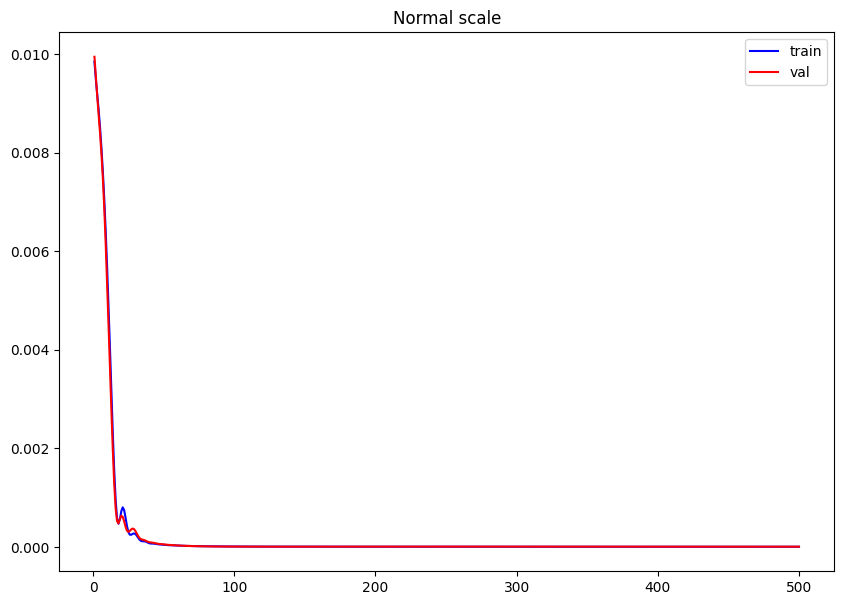

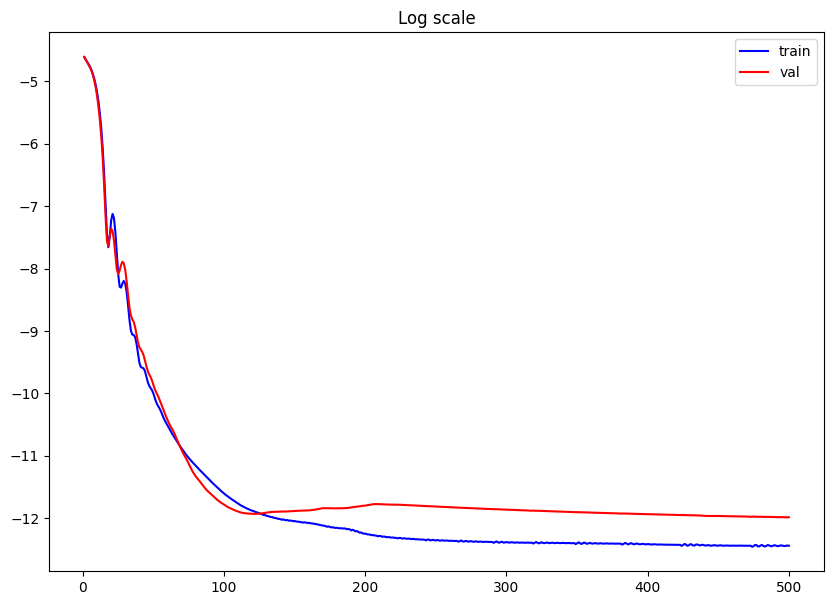

In [28]:
model.plot_train()

In [29]:
model_MLP = model.model

### vi. Performance Metrics

In [30]:
train_predict = model_MLP(X_train)
train_predict = torch.reshape(train_predict, (-1, ))
train_predict = list(train_predict.detach().cpu().numpy())

X_train_col = torch.reshape(X_train, (-1, ))
X_train_col = list(X_train_col.detach().cpu().numpy())

y_train_col = torch.reshape(y_train, (-1, ))
y_train_col = list(y_train_col.detach().cpu().numpy())

df_train = pd.DataFrame()
df_train['X'] = X_train_col
df_train['y'] = y_train_col
df_train['y_predict'] = train_predict

df_train['X'] = df_train['X']*X_train_std[0] + X_train_mean[0]
df_train['y'] = df_train['y']*y_train_std + y_train_mean
df_train['y_predict'] = df_train['y_predict']*y_train_std + y_train_mean

In [31]:
val_predict = model_MLP(X_val)
val_predict = torch.reshape(val_predict, (-1, ))
val_predict = list(val_predict.detach().cpu().numpy())

X_val_col = torch.reshape(X_val, (-1, ))
X_val_col = list(X_val_col.detach().cpu().numpy())

y_val_col = torch.reshape(y_val, (-1, ))
y_val_col = list(y_val_col.detach().cpu().numpy())

df_val = pd.DataFrame()
df_val['X'] = X_val_col
df_val['y'] = y_val_col
df_val['y_predict'] = val_predict

df_val['X'] = df_val['X']*X_train_std[0] + X_train_mean[0]
df_val['y'] = df_val['y']*y_train_std + y_train_mean
df_val['y_predict'] = df_val['y_predict']*y_train_std + y_train_mean

In [32]:
test_predict = model_MLP(X_test)
test_predict = torch.reshape(test_predict, (-1, ))
test_predict = list(test_predict.detach().cpu().numpy())

X_test_col = torch.reshape(X_test, (-1, ))
X_test_col = list(X_test_col.detach().cpu().numpy())

y_test_col = torch.reshape(y_test, (-1, ))
y_test_col = list(y_test_col.detach().cpu().numpy())

df_test = pd.DataFrame()
df_test['X'] = X_test_col
df_test['y'] = y_test_col
df_test['y_predict'] = test_predict

df_test['X'] = df_test['X']*X_train_std[0] + X_train_mean[0]
df_test['y'] = df_test['y']*y_train_std + y_train_mean
df_test['y_predict'] = df_test['y_predict']*y_train_std + y_train_mean

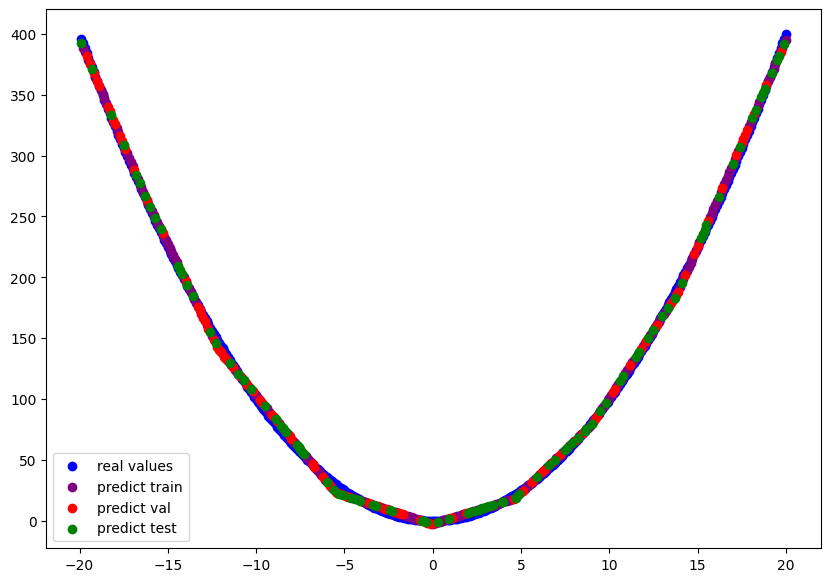

In [33]:
plt.figure(figsize = (10, 7))

plt.scatter(df_train['X'], df_train['y'], color = 'blue', label = 'real values')
plt.scatter(df_val['X'], df_val['y'], color = 'blue')
plt.scatter(df_test['X'], df_test['y'], color = 'blue')

plt.scatter(df_train['X'], df_train['y_predict'], color = 'purple', label = 'predict train')
plt.scatter(df_val['X'], df_val['y_predict'], color = 'red', label = 'predict val')
plt.scatter(df_test['X'], df_test['y_predict'], color = 'green', label = 'predict test')

plt.legend()
plt.show()

In [34]:
mae_train = round(abs(df_train['y_predict'] - df_train['y']).mean(), 2)
mae_val = round(abs(df_val['y_predict'] - df_val['y']).mean(), 2)
mae_test = round(abs(df_test['y_predict'] - df_test['y']).mean(), 2)

print('MAE train: ', mae_train)
print('MAE val: ', mae_val)
print('MAE test: ', mae_test)

MAE train:  1.98
MAE val:  2.53
MAE test:  2.18


### vii. Explainability

In [35]:
!pip install -q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.5 MB/s eta 0:00:00


In [36]:
import shap

In [37]:
def MLP_predict(df_X):

  df_X_tensor = torch.tensor(np.array(df_X))
  y_pred = model_MLP(df_X_tensor)
  y_pred = torch.reshape(y_pred, (-1, 1))
  y_pred = y_pred.detach().cpu().numpy()
  y_pred = y_pred[:, 0]

  return y_pred

In [38]:
explainer = shap.KernelExplainer(MLP_predict, df_test[['X']])

In [39]:
shap_values = explainer.shap_values(df_test[['X']])

  0%|          | 0/100 [00:00<?, ?it/s]

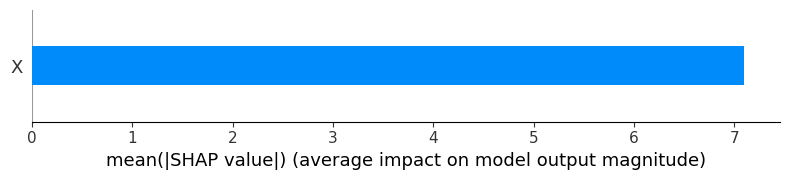

In [40]:
shap.summary_plot(shap_values, df_test[['X']], plot_type = "bar")

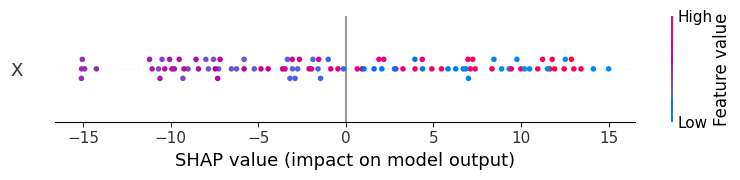

In [41]:
shap.summary_plot(shap_values, df_test[['X']])

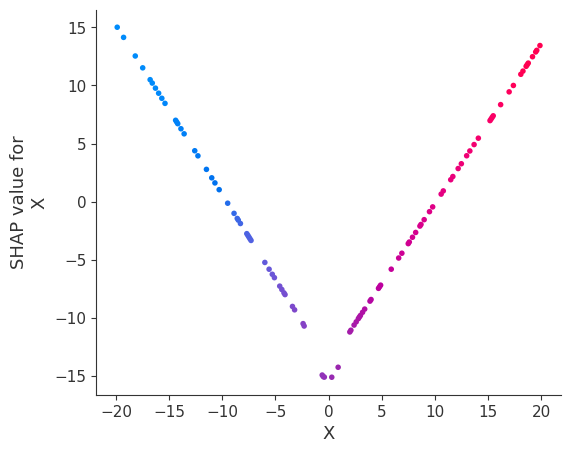

In [42]:
for name in ['X']:
    shap.dependence_plot(name, shap_values, df_test[['X']])

# 2. Classification Problem

### i. Creacion of Dataset

In [43]:
from sklearn.datasets import make_circles, make_classification

In [44]:
X, y = make_classification(
    n_samples = 400, n_features = 2, n_redundant = 0, n_informative = 2, random_state = 1,
    n_clusters_per_class = 2, class_sep = 0.7
)

In [45]:
df = pd.DataFrame()
df['X_1'] = X[:, 0]
df['X_2'] = X[:, 1]
df['y'] = y
df['y_2'] = 1 - df['y']

In [46]:
df['X_1'] = df['X_1'].astype('float32')
df['X_2'] = df['X_2'].astype('float32')
df['y'] = df['y'].astype('float32')
df['y_2'] = df['y_2'].astype('float32')

In [47]:
X = df[['X_1', 'X_2']].copy()
y = df[['y', 'y_2']].copy()

In [48]:
f_0 = (df['y'] == 0)
f_1 = (df['y'] == 1)

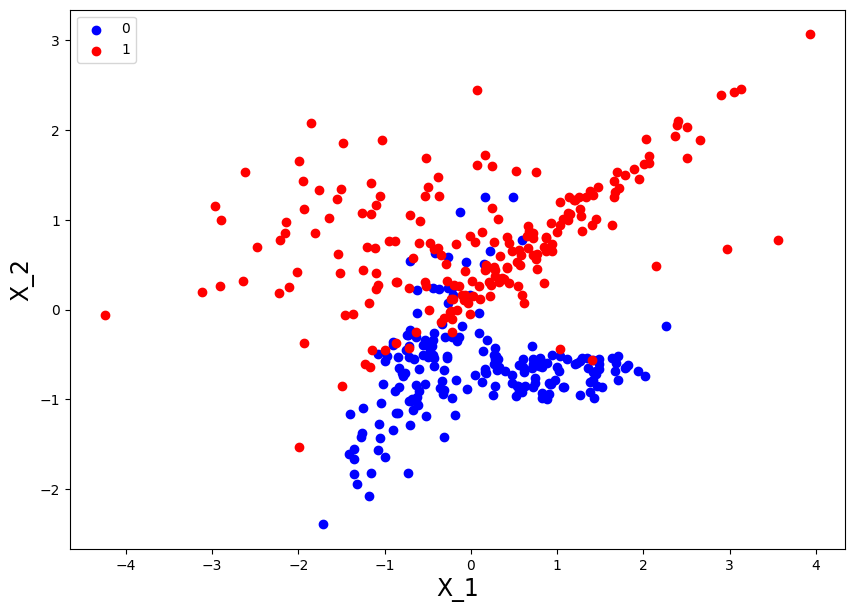

In [49]:
plt.figure(figsize = (10, 7))
plt.xlabel('X_1', fontsize = 17)
plt.ylabel('X_2', fontsize = 17)
plt.scatter(df[f_0]['X_1'], df[f_0]['X_2'], color = 'blue', label = '0')
plt.scatter(df[f_1]['X_1'], df[f_1]['X_2'], color = 'red', label = '1')
plt.legend()
plt.show()

### ii. Split

In [50]:
n_batchs = 2

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.5, random_state = 42)

In [52]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state = 42)

In [53]:
X_train_mean = X_train.mean()
X_train_std = X_train.std()

X_train = (X_train - X_train_mean)/X_train_std
X_val = (X_val - X_train_mean)/X_train_std
X_test = (X_test - X_train_mean)/X_train_std

In [54]:
all_X_train, all_y_train = creation_batchs(n_batchs, X_train, y_train)

In [55]:
for i in range(n_batchs):
  all_X_train[i] = torch.tensor(np.array(all_X_train[i]))
  all_y_train[i] = torch.tensor(np.array(all_y_train[i]))

X_train = torch.tensor(np.array(X_train))
y_train = torch.tensor(np.array(y_train))

X_val = torch.tensor(np.array(X_val))
y_val = torch.tensor(np.array(y_val))

X_test = torch.tensor(np.array(X_test))
y_test = torch.tensor(np.array(y_test))

### iii. Creation of model

In [56]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [57]:
class MLP(nn.Module):

    def __init__(self, input_size, hidden_dim_1, hidden_dim_2, output_size):
        super(MLP, self).__init__()

        #----------------------------------------------------------------------

        self.input_size = input_size

        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2

        self.output_size = output_size

        #----------------------------------------------------------------------

        self.fc_entry = nn.Linear(self.input_size, self.hidden_dim_1)

        self.fc_1 = nn.Linear(self.hidden_dim_1, self.hidden_dim_2)
        self.fc_2 = nn.Linear(self.hidden_dim_2, self.output_size)

        self.activation_1 = nn.ReLU()
        self.activation_2 = nn.ReLU()

        self.logsoftmax = nn.LogSoftmax(dim = 1)

        #----------------------------------------------------------------------


    def forward(self, x):

        out = self.fc_entry(x)
        out = self.activation_1(out)

        out = self.fc_1(out)
        out = self.activation_2(out)

        out = self.fc_2(out)

        out = self.logsoftmax(out)

        return out

In [58]:
class Model():

  def __init__(self, input_size, hidden_dim_1, hidden_dim_2, output_size, n_epochs, lr):

    self.input_size = input_size
    self.hidden_dim_1 = hidden_dim_1
    self.hidden_dim_2 = hidden_dim_2
    self.output_size = output_size

    self.n_epochs = n_epochs
    self.lr = lr

    self.model = MLP(input_size, hidden_dim_1, hidden_dim_2, output_size)


  def train(self):

    start_train = time.time()

    #----------------------------------------------------------------------

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.model.parameters(), lr = self.lr)

    #----------------------------------------------------------------------

    all_train_loss = []
    all_val_loss = []
    all_epochs = []

    all_train_recall = []
    all_val_recall = []

    #----------------------------------------------------------------------

    for epoch in range(1, self.n_epochs + 1):

      # 1. Train

      self.model.train()

      loss_train_epoch = 0
      recall_train_epoch = 0

      for n_iter in range(n_batchs):

        X_train_batch = all_X_train[n_iter]
        y_train_batch = all_y_train[n_iter]

        optimizer.zero_grad() # Clears existing gradients

        out_train_batch = self.model(X_train_batch)

        loss_train_batch = criterion(out_train_batch, y_train_batch)

        recall_train_batch = recall_score(y_train_batch.detach().cpu().numpy()[:, 0], (np.exp(out_train_batch.detach().cpu().numpy())[:, 0] >= 0.5)*1, average='macro')*100
        recall_train_epoch = recall_train_epoch + recall_train_batch

        loss_train_batch.backward()
        optimizer.step() # Updates the weights accordingly

        loss_train_epoch = loss_train_epoch + loss_train_batch.item()

      loss_train_epoch = loss_train_epoch/len(X_train)
      recall_train_epoch = recall_train_epoch/n_batchs

      all_train_loss.append(loss_train_epoch)
      all_epochs.append(epoch)
      all_train_recall.append(recall_train_epoch)


      # 2. Validation

      self.model.eval()

      out_val = self.model(X_val)

      loss_val = criterion(out_val, y_val).item()/len(X_val)

      recall_val = recall_score(y_val.detach().cpu().numpy()[:, 0], (np.exp(out_val.detach().cpu().numpy())[:, 0] >= 0.5)*1, average='macro')*100

      all_val_loss.append(loss_val)
      all_val_recall.append(recall_val)

    #----------------------------------------------------------------------

    end_train = time.time()

    self.all_epochs = all_epochs

    self.all_train_loss = all_train_loss
    self.all_val_loss = all_val_loss

    self.all_train_recall = all_train_recall
    self.all_val_recall = all_val_recall

    return print_time_execution(start_train, end_train, 'in train the model')


  def plot_train(self):

    plt.figure(figsize = (10, 7))
    plt.title('Normal scale')
    plt.plot(self.all_epochs, self.all_train_loss, label = 'train', color = 'blue')
    plt.plot(self.all_epochs, self.all_val_loss, label = 'val', color = 'red')
    plt.legend()
    plt.show()

    print('\n')
    print('\n')
    print('\n')

    plt.figure(figsize = (10, 7))
    plt.title('Log scale')
    plt.plot(self.all_epochs, np.log(np.array(self.all_train_loss)), label = 'train', color = 'blue')
    plt.plot(self.all_epochs, np.log(np.array(self.all_val_loss)), label = 'val', color = 'red')
    plt.legend()
    plt.show()

    print('\n')
    print('\n')
    print('\n')

    plt.figure(figsize = (10, 7))
    plt.title('Recall')
    plt.plot(self.all_epochs, self.all_train_recall, label = 'train', color = 'blue')
    plt.plot(self.all_epochs, self.all_val_recall, label = 'val', color = 'red')
    plt.legend()
    plt.show()


  def evaluation_val_set(self):

    criterion = nn.MSELoss()

    self.model.eval()

    out_val = self.model(X_val)

    loss_val = criterion(out_val, y_val).item()/len(X_val)

    return loss_val


### iv. Hyperparameter Tuning Jobs

In [59]:
input_size = 2
output_size = 2

all_hidden_dim_1 = [(i*2) for i in range(1, 3 + 1)]
all_hidden_dim_2 = [(i*2) for i in range(1, 3 + 1)]
all_n_epochs = [(i*100) for i in range(1, 3 + 1)]
all_lr = [(i*0.01) for i in range(1, 3 + 1)]

all_params = []

for hidden_dim_1 in all_hidden_dim_1:
  for hidden_dim_2 in all_hidden_dim_2:
    for n_epochs in all_n_epochs:
      for lr in all_lr:
        all_params.append({'hidden_dim_1': hidden_dim_1, 'hidden_dim_2': hidden_dim_2, 'n_epochs': n_epochs, 'lr': lr})

In [60]:
hidden_dim_1_col = []
hidden_dim_2_col = []

n_epochs_col = []
lr_col = []

loss_val_col = []

c = 0

start_iter = time.time()

m = 10

for params in all_params:

  c = c + 1

  hidden_dim_1 = params['hidden_dim_1']
  hidden_dim_2 = params['hidden_dim_2']

  n_epochs = params['n_epochs']
  lr = params['lr']

  model = Model(input_size, hidden_dim_1, hidden_dim_2, output_size, n_epochs, lr)
  _ = model.train()
  loss_val = model.evaluation_val_set()

  hidden_dim_1_col.append(hidden_dim_1)
  hidden_dim_2_col.append(hidden_dim_2)

  n_epochs_col.append(n_epochs)
  lr_col.append(lr)

  loss_val_col.append(loss_val)

  if (c % m) == 0:

    end_iter = time.time()
    print(f'c = {c}')
    print(print_time_execution(start_iter, end_iter, f'execute {m} iterations'))
    print('-'*70)
    start_iter = time.time()

c = 10
execute 10 iterations it takes 0 hours, 0 mins and 26 segs.
----------------------------------------------------------------------
c = 20
execute 10 iterations it takes 0 hours, 0 mins and 23 segs.
----------------------------------------------------------------------
c = 30
execute 10 iterations it takes 0 hours, 0 mins and 15 segs.
----------------------------------------------------------------------
c = 40
execute 10 iterations it takes 0 hours, 0 mins and 16 segs.
----------------------------------------------------------------------
c = 50
execute 10 iterations it takes 0 hours, 0 mins and 15 segs.
----------------------------------------------------------------------
c = 60
execute 10 iterations it takes 0 hours, 0 mins and 17 segs.
----------------------------------------------------------------------
c = 70
execute 10 iterations it takes 0 hours, 0 mins and 18 segs.
----------------------------------------------------------------------
c = 80
execute 10 iterations it ta

In [61]:
ht = pd.DataFrame()
ht['hidden_dim_1'] = hidden_dim_1_col
ht['hidden_dim_2'] = hidden_dim_2_col
ht['n_epochs'] = n_epochs_col
ht['lr'] = lr_col
ht['loss_val'] = loss_val_col

In [62]:
hidden_dim_1_opt, hidden_dim_2_opt, n_epochs_opt, lr_opt, _ = ht[ht['loss_val'] == ht['loss_val'].min()].iloc[0]

In [63]:
hidden_dim_1_opt = int(hidden_dim_1_opt)
hidden_dim_2_opt = int(hidden_dim_2_opt)
n_epochs_opt = int(n_epochs_opt)

In [64]:
hidden_dim_1_opt, hidden_dim_2_opt, n_epochs_opt, lr_opt

(6, 2, 300, 0.03)

### v. Definitive model

In [65]:
model = Model(input_size, hidden_dim_1_opt, hidden_dim_2_opt, output_size, n_epochs_opt, lr_opt)

In [66]:
model.train()

'in train the model it takes 0 hours, 0 mins and 2 segs.'

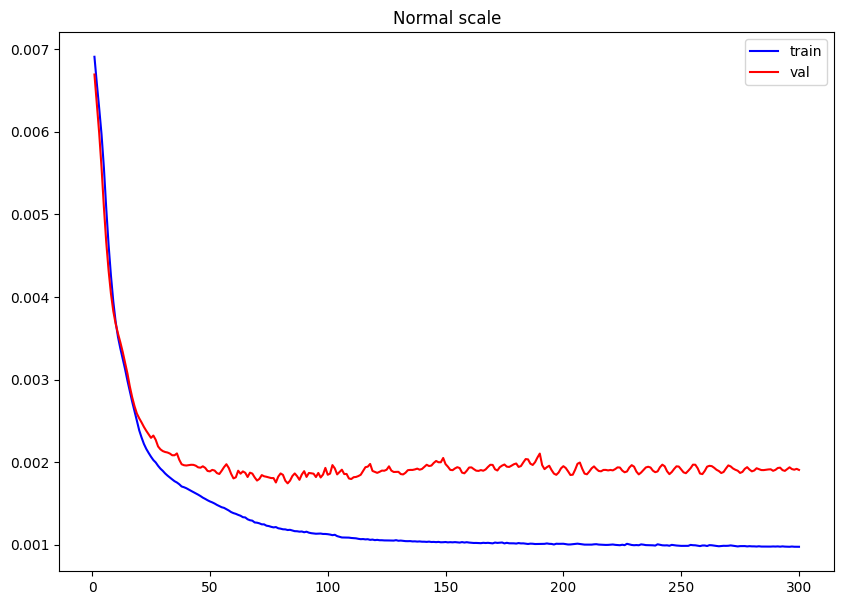

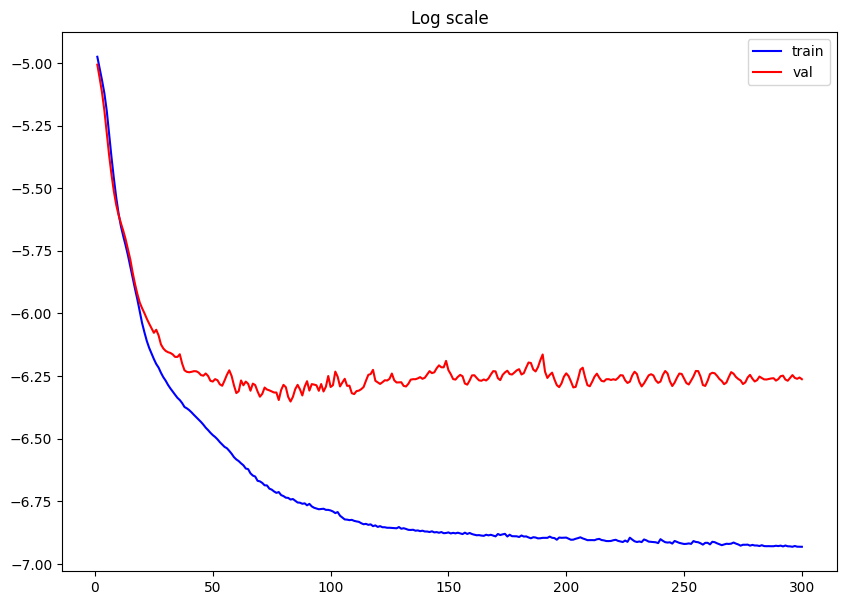

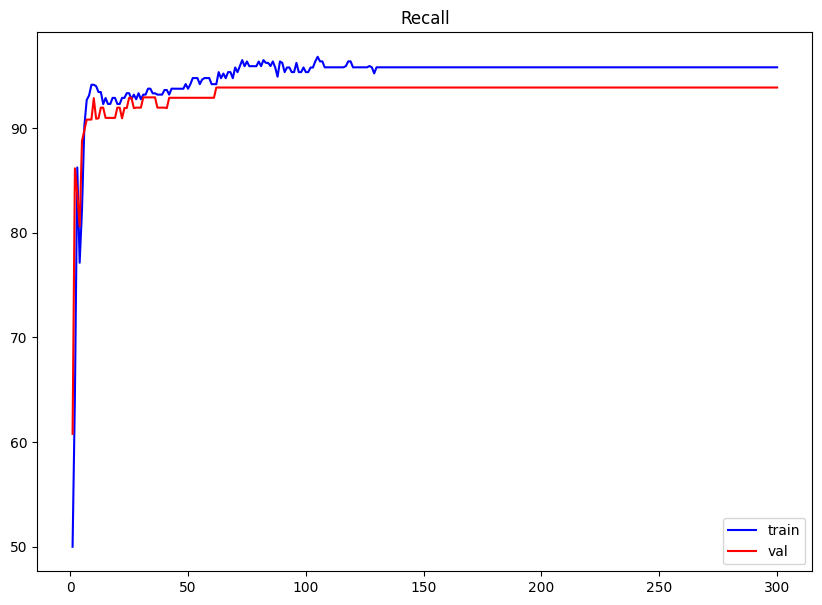

In [67]:
model.plot_train()

In [68]:
model_MLP = model.model

### vi. Performance Metrics

In [69]:
df_train = pd.DataFrame()
df_train['X_1'] = X_train.detach().cpu().numpy()[:, 0]
df_train['X_2'] = X_train.detach().cpu().numpy()[:, 1]
df_train['y'] = y_train.detach().cpu().numpy()[:, 0]
df_train['prob'] = np.exp(model_MLP(X_train).detach().cpu().numpy())[:, 0]
df_train['y_pred'] = (df_train['prob'] >= 0.5)*1

In [70]:
df_val = pd.DataFrame()
df_val['X_1'] = X_val.detach().cpu().numpy()[:, 0]
df_val['X_2'] = X_val.detach().cpu().numpy()[:, 1]
df_val['y'] = y_val.detach().cpu().numpy()[:, 0]
df_val['prob'] = np.exp(model_MLP(X_val).detach().cpu().numpy())[:, 0]
df_val['y_pred'] = (df_val['prob'] >= 0.5)*1

In [71]:
df_test = pd.DataFrame()
df_test['X_1'] = X_test.detach().cpu().numpy()[:, 0]
df_test['X_2'] = X_test.detach().cpu().numpy()[:, 1]
df_test['y'] = y_test.detach().cpu().numpy()[:, 0]
df_test['prob'] = np.exp(model_MLP(X_test).detach().cpu().numpy())[:, 0]
df_test['y_pred'] = (df_test['prob'] >= 0.5)*1

In [72]:
round(recall_score(df_train['y'], df_train['y_pred'])*100, 2)

96.0

In [73]:
round(precision_score(df_train['y'], df_train['y_pred'])*100, 2)

96.0

In [74]:
round(recall_score(df_val['y'], df_val['y_pred'])*100, 2)

100.0

In [75]:
round(precision_score(df_val['y'], df_val['y_pred'])*100, 2)

89.47

In [76]:
round(recall_score(df_test['y'], df_test['y_pred'])*100, 2)

78.43

In [77]:
round(precision_score(df_test['y'], df_test['y_pred'])*100, 2)

90.91

### vii. Explainability

In [78]:
!pip install -q shap

In [79]:
import shap

In [80]:
def MLP_predict(df_X):

  df_X_tensor = torch.tensor(np.array(df_X))
  y_pred = model_MLP(df_X_tensor)
  y_pred = np.exp(y_pred.detach().cpu().numpy())
  y_pred = y_pred

  return y_pred

In [81]:
explainer = shap.KernelExplainer(MLP_predict, df_test[['X_1', 'X_2']])

In [82]:
shap_values = explainer.shap_values(df_test[['X_1', 'X_2']])

  0%|          | 0/100 [00:00<?, ?it/s]

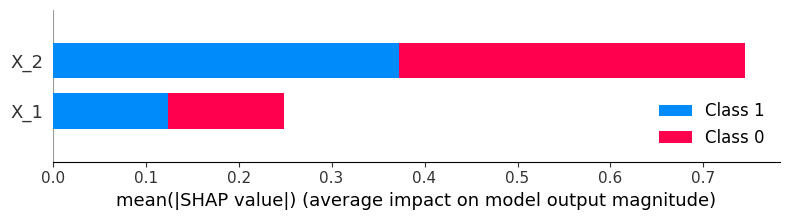

In [83]:
shap.summary_plot(shap_values, df_test[['X_1', 'X_2']], plot_type = "bar")

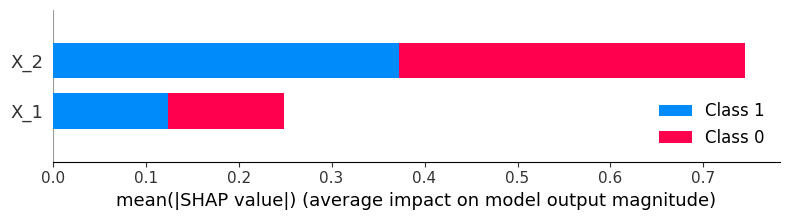

In [84]:
shap.summary_plot(shap_values, df_test[['X_1', 'X_2']])

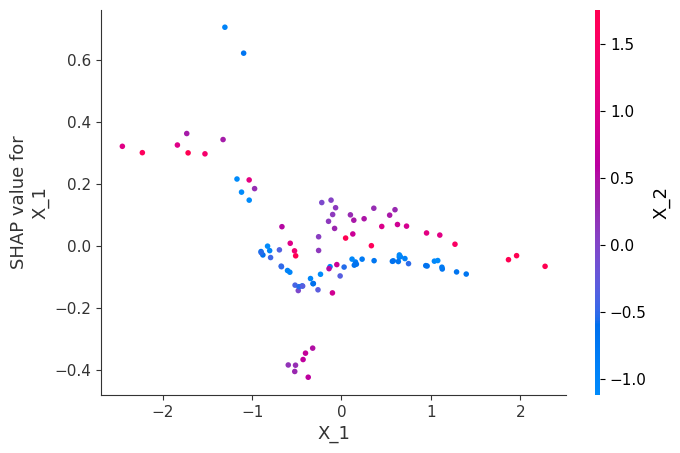

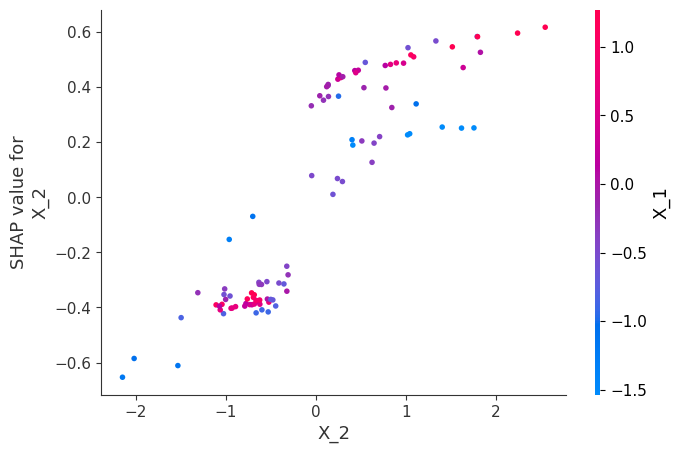

In [85]:
for name in ['X_1', 'X_2']:
    shap.dependence_plot(name, shap_values[0], df_test[['X_1', 'X_2']])

### End time of execution

In [86]:
end = time.time()

In [87]:
print(print_time_execution(start, end, 'notebook execution'))

notebook execution it takes 0 hours, 12 mins and 39 segs.
